# One step univariate model - ARIMA

Download zipfile from https://www.dropbox.com/s/pqenrr2mcvl0hk9/GEFCom2014.zip?dl=0 and store in the data folder.

In this notebook, we demonstrate how to:
- prepare time series data for training a RNN forecasting model
- get data in the required shape for the keras API
- implement a simple RNN model in keras to predict the next step ahead (time *t+1*) in the time series
- enable early stopping to reduce the likelihood of model overfitting
- evaluate the model on a test dataset

The data in this example is taken from the GEFCom2014 forecasting competition<sup>1</sup>. It consists of 3 years of hourly electricity load and temperature values between 2012 and 2014. The task is to forecast future values of electricity load. In this example, we show how to forecast one time step ahead, using historical load data only.

<sup>1</sup>Tao Hong, Pierre Pinson, Shu Fan, Hamidreza Zareipour, Alberto Troccoli and Rob J. Hyndman, "Probabilistic energy forecasting: Global Energy Forecasting Competition 2014 and beyond", International Journal of Forecasting, vol.32, no.3, pp 896-913, July-September, 2016.

In [146]:
import os
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
from collections import UserDict
%matplotlib inline

from pandas import DataFrame
from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pyplot
from sklearn.preprocessing import MinMaxScaler

pd.options.display.float_format = '{:,.2f}'.format
np.set_printoptions(precision=2)
warnings.filterwarnings("ignore") # specify to ignore warning messages

In [5]:
if not os.path.exists(os.path.join('data', 'energy.csv')):
    # Download and move the zip file
    !wget https://www.dropbox.com/s/pqenrr2mcvl0hk9/GEFCom2014.zip
    !mv GEFCom2014.zip ./data
    # If not done already, extract zipped data and save as csv
    %run common/extract_data.py

Load the data from csv into a Pandas dataframe

In [6]:
# %load common/load_data.py
def load_data():

    # read GEFCom2014 load data

    data_dir = 'data/'

    energy = pd.read_csv(os.path.join(data_dir, 'energy.csv'), parse_dates=['timestamp'])

    # Reindex the dataframe such that the dataframe has a record for every time point
    # between the minimum and maximum timestamp in the time series. This helps to 
    # identify missing time periods in the data (there are none in this dataset).

    energy.index = energy['timestamp']
    energy = energy.reindex(pd.date_range(min(energy['timestamp']),
                                          max(energy['timestamp']),
                                          freq='H'))
    energy = energy.drop('timestamp', axis=1)

    return energy

In [7]:
energy = load_data()[['load']]
energy.head()

,load
2012-01-01 00:00:00,"2,698.00"
2012-01-01 01:00:00,"2,558.00"
2012-01-01 02:00:00,"2,444.00"
2012-01-01 03:00:00,"2,402.00"
2012-01-01 04:00:00,"2,403.00"


Plot all available load data (January 2012 to Dec 2014)

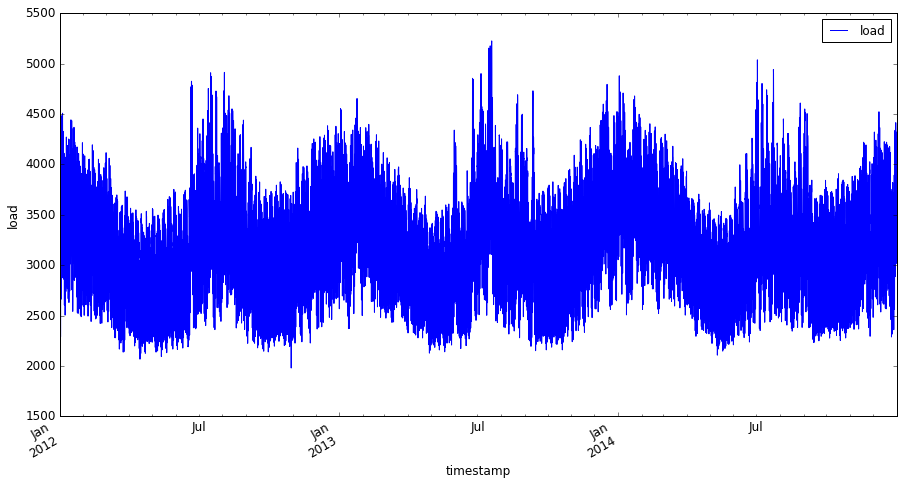

In [8]:
energy.plot(y='load', subplots=True, figsize=(15, 8), fontsize=12)
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('load', fontsize=12)
plt.show()

Plot first week of July 2014

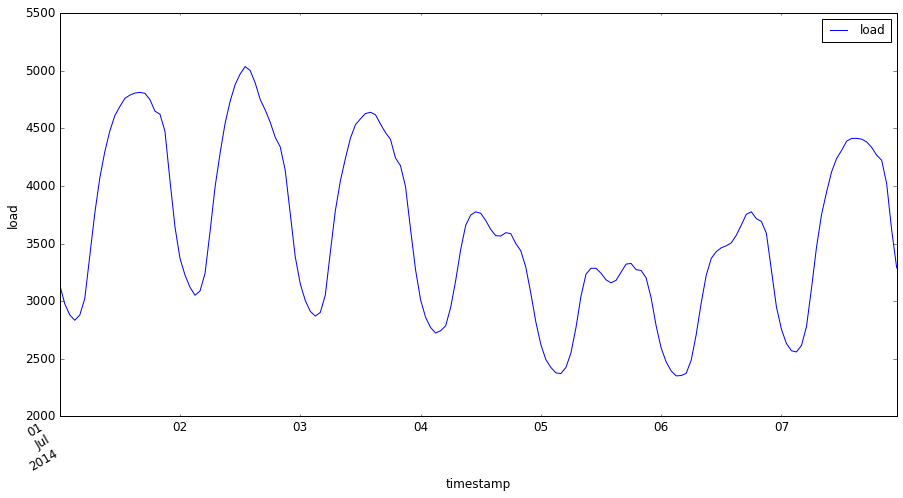

In [9]:
energy['2014-07-01':'2014-07-07'].plot(y='load', subplots=True, figsize=(15, 8), fontsize=12)
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('load', fontsize=12)
plt.show()

## Create train, validation and test sets

We separate our dataset into train, validation and test sets. We train the model on the train set. The validation set is used to evaluate the model after each training epoch and ensure that the model is not overfitting the training data. After the model has finished training, we evaluate the model on the test set. We must ensure that the validation set and test set cover a later period in time from the training set, to ensure that the model does not gain from information from future time periods.

We will allocate the period 1st November 2014 to 31st December 2014 to the test set. The period 1st September 2014 to 31st October is allocated to validation set. All other time periods are available for the training set.

In [10]:
valid_start_dt = '2014-09-01 00:00:00'
test_start_dt = '2014-11-01 00:00:00'

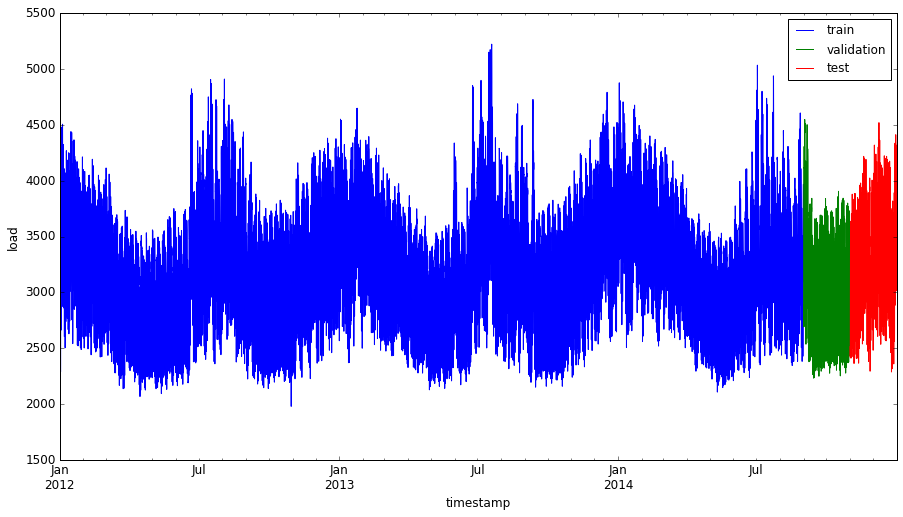

In [11]:
energy[energy.index < valid_start_dt][['load']].rename(columns={'load':'train'}) \
    .join(energy[(energy.index >=valid_start_dt) & (energy.index < test_start_dt)][['load']] \
          .rename(columns={'load':'validation'}), how='outer') \
    .join(energy[test_start_dt:][['load']].rename(columns={'load':'test'}), how='outer') \
    .plot(y=['train', 'validation', 'test'], figsize=(15, 8), fontsize=12)
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('load', fontsize=12)
plt.show()

In [28]:
energy.head(5)

,load
2012-01-01 00:00:00,"2,698.00"
2012-01-01 01:00:00,"2,558.00"
2012-01-01 02:00:00,"2,444.00"
2012-01-01 03:00:00,"2,402.00"
2012-01-01 04:00:00,"2,403.00"


## Data preparation


In [406]:
# HORIZON=1 specifies that we have a forecasting horizon of 1 (t+1)
HORIZON = 1

Our data preparation for the training set will involve the following steps:

1. Filter the original dataset to include only that time period reserved for the training set
2. Scale the time series such that the values fall within the interval (0, 1)

Create training set containing only the model features

In [407]:
train = energy.copy()[energy.index < test_start_dt][['load']]
test = energy.copy()[energy.index >= test_start_dt][['load']]

print(train.shape)
print(test.shape)

(26256, 1)
(48, 1)


Scale data to be in range (0, 1). This transformation should be calibrated on the training set only. This is to prevent information from the validation or test sets leaking into the training data.

In [408]:

scaler = MinMaxScaler()
train['load'] = scaler.fit_transform(train)
train.head(10)

,load
2012-01-01 00:00:00,0.22
2012-01-01 01:00:00,0.18
2012-01-01 02:00:00,0.14
2012-01-01 03:00:00,0.13
2012-01-01 04:00:00,0.13
2012-01-01 05:00:00,0.15
2012-01-01 06:00:00,0.18
2012-01-01 07:00:00,0.23
2012-01-01 08:00:00,0.29
2012-01-01 09:00:00,0.35


Original vs scaled data:

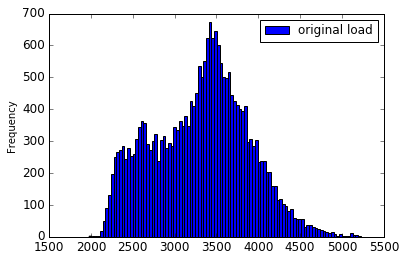

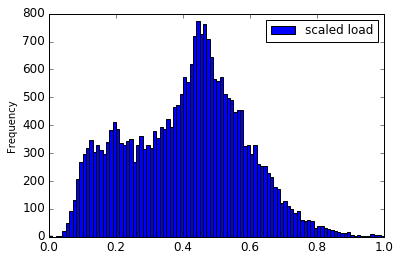

In [409]:
energy[energy.index < valid_start_dt][['load']].rename(columns={'load':'original load'}).plot.hist(bins=100, fontsize=12)
train.rename(columns={'load':'scaled load'}).plot.hist(bins=100, fontsize=12)
plt.show()

Now we follow a similar process for the validation set. We keep T hours from the training set in order to construct initial features.

## Implement ARIMA method

An ARIMA model can be created using the statsmodels library. In the next section, we perform the following steps:
1. Define the model by calling ARIMA() and passing in the p, d, and q parameters.
2. The model is prepared on the training data by calling the fit() function.
3. Predictions can be made by calling the forecast() function and specifying the number of steps (horizon) which to forecast

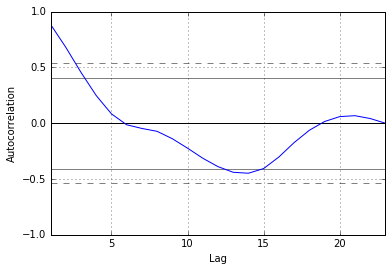

In [410]:
from pandas.tools.plotting import autocorrelation_plot

autocorrelation_plot(train[1:24])
pyplot.show()

In [411]:
# fit model
model = ARIMA(train, order=(5,1,0))
model_fit = model.fit(disp=0)
print(model_fit.summary().tables[1])

                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const         6.335e-06      0.000      0.014      0.989      -0.001       0.001
ar.L1.D.load     1.2915      0.006    210.427      0.000       1.279       1.304
ar.L2.D.load    -0.7687      0.010    -76.591      0.000      -0.788      -0.749
ar.L3.D.load     0.3532      0.011     32.445      0.000       0.332       0.374
ar.L4.D.load    -0.1118      0.010    -11.137      0.000      -0.131      -0.092
ar.L5.D.load    -0.1047      0.006    -17.058      0.000      -0.117      -0.093


Next we display the distribution of residuals. A zero mean in the residuals show that there is no bias in the prediction. 

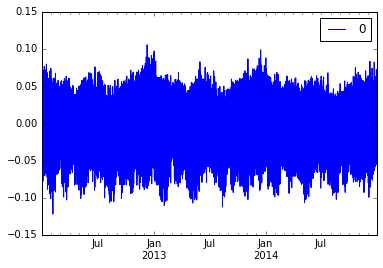

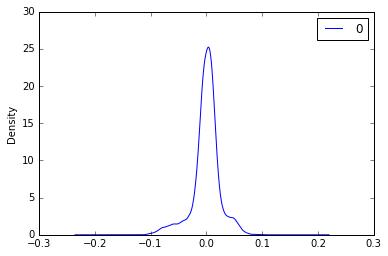

              0
count 26,255.00
mean      -0.00
std        0.02
min       -0.12
25%       -0.01
50%        0.00
75%        0.01
max        0.11


In [412]:
# plot residual errors
residuals = DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()
residuals.plot(kind='kde')
pyplot.show()
print(residuals.describe())

## Evaluate the model

Scale the test data

In [413]:
test['load'] = scaler.transform(test)
test.head()

,load
2014-12-30 00:00:00,0.32
2014-12-30 01:00:00,0.29
2014-12-30 02:00:00,0.28
2014-12-30 03:00:00,0.28
2014-12-30 04:00:00,0.30


Create a test data point for each horizon step.

In [414]:
test_shifted = test.copy()

for t in range(1, HORIZON):
    test_shifted['load+'+str(t)] = test_shifted['load'].shift(-t, freq='H')
    
test_shifted = test_shifted.dropna(how='any')
test_shifted.head(5)

,load
2014-12-30 00:00:00,0.32
2014-12-30 01:00:00,0.29
2014-12-30 02:00:00,0.28
2014-12-30 03:00:00,0.28
2014-12-30 04:00:00,0.30


Make predictions on the test data

In [415]:
train_ts = train['load']
test_ts = test_shifted

history = [x for x in train_ts]
predictions = list()

for t in range(test_ts.shape[0]):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast(steps = HORIZON)
    yhat = output[0]
    predictions.append(yhat)
    obs = list(test_ts.iloc[t])
    history.append(obs[0])
    # print('predicted=', yhat, 'expected=', obs)

Compare predictions to actual load

In [416]:
eval_df = pd.DataFrame(predictions, columns=['t+'+str(t) for t in range(1, HORIZON+1)])

eval_df['timestamp'] = test.index[0:len(test.index)-HORIZON+1]
eval_df = pd.melt(eval_df, id_vars='timestamp', value_name='prediction', var_name='h')
eval_df['actual'] = np.array(np.transpose(test_ts)).ravel()
eval_df[['prediction', 'actual']] = scaler.inverse_transform(eval_df[['prediction', 'actual']])
eval_df.head()

,timestamp,h,prediction,actual
0,2014-12-30 00:00:00,t+1,"3,057.08","3,023.00"
1,2014-12-30 01:00:00,t+1,"2,918.86","2,935.00"
2,2014-12-30 02:00:00,t+1,"2,931.66","2,899.00"
3,2014-12-30 03:00:00,t+1,"2,918.59","2,886.00"
4,2014-12-30 04:00:00,t+1,"2,912.72","2,963.00"


Compute the mean absolute percentage error over all predictions

In [417]:
# %load common/mape.py
def mape(predictions, actuals):
    return ((predictions - actuals).abs() / actuals).mean()


In [418]:
mape(eval_df['prediction'], eval_df['actual'])

0.013362364571240818

Plot the predictions vs the actuals for the first week of the test set

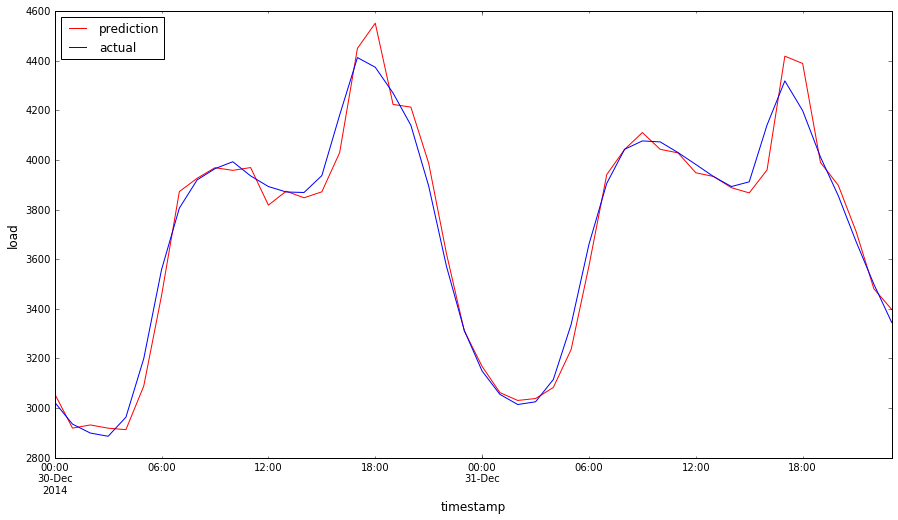

In [419]:
eval_df.plot(x='timestamp', y=['prediction', 'actual'], style=['r', 'b'], figsize=(15, 8))
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('load', fontsize=12)
plt.show()